In [13]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath("__file__")))

import time 
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import CLIPTokenizerFast

from src_emotion.datasets.dataset_video_retrieval import (
    HDVILAVideoRetrievalDataset, VideoRetrievalCollator)

from src_emotion.configs.config import shared_configs
from src_emotion.utils.misc import set_random_seed
from src_emotion.utils.logger import LOGGER
from src_emotion.utils.load_save import load_state_dict_with_mismatch
from src_emotion.utils.emotion_utils import encode_query

from src_emotion.utils.metrics import cal_cossim

# README
* Not using havarod library but cuda

In [14]:
def mk_video_ret_dataloader(dataset_name, vis_format, anno_path, vis_dir, cfg, tokenizer, mode):
    is_train = mode == "train"
    dataset = HDVILAVideoRetrievalDataset(
        cfg=cfg,
        vis_dir=vis_dir,
        anno_path=anno_path,
        vis_format=vis_format,
        mode=mode
    )
    LOGGER.info(f"[{dataset_name}] is_train {is_train} "
                f"dataset size {len(dataset)}, ")

    batch_size = cfg.train_batch_size if is_train else cfg.test_batch_size
    vret_collator = VideoRetrievalCollator(
        tokenizer=tokenizer, max_length=cfg.max_txt_len, is_train=is_train)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=cfg.n_workers,
                            pin_memory=cfg.pin_mem,
                            collate_fn=vret_collator.collate_batch)
    return dataloader


def setup_model(cfg, device=None):
    LOGGER.info("Setup model...")
    
    if cfg.is_embed:
        from src_emotion.modeling.VidCLIP import VidCLIP
        model = VidCLIP(cfg)
    else:
        from src.modeling.VidCLIP import VidCLIP
        model = VidCLIP(cfg)

    if cfg.e2e_weights_path:
        LOGGER.info(f"Loading e2e weights from {cfg.e2e_weights_path}")
        
        load_state_dict_with_mismatch(model, cfg.e2e_weights_path)
    
    if hasattr(cfg, "overload_logit_scale"):
        model.overload_logit_scale(cfg.overload_logit_scale)
    
    model.to(device)

    LOGGER.info("Setup model done!")
    return model

# Arguments

* script 파일(.py)는 dummy script일 뿐이라서 아래의 config 에서 활용되지 않음. 즉, 무시해도 됨.
* script 파일(.py) 이후의 arguments 들만 아래의 셀들에서 활용됨.

### Baseline Model

In [15]:
sys.argv = ['src/tasks/run_video_retrieval.py', '--config', './src_emotion/configs/msrvtt_retrieval/demo_retrieval_vip_base_32.json',
            '--query', 'There are many people happy']
cfg_base = shared_configs.parse_args()
cfg_base.e2e_weights_path = cfg_base.base_e2e_weights_path # overwrite the weight path
cfg_base.is_embed = False
cfg_base.is_demo = True
cfg_base.emotion = encode_query(cfg_base.query, None)

### Emotion Embedding Model

In [16]:
sys.argv = ['src/tasks/run_video_retrieval.py', '--config', './src_emotion/configs/msrvtt_retrieval/demo_retrieval_vip_base_32.json',
            '--query', 'There are many people happy']
cfg_embed = shared_configs.parse_args()
cfg_embed.is_embed = True
cfg_embed.is_demo = True
cfg_embed.emotion = encode_query(cfg_embed.query, None)

# Load Test Data

In [17]:
set_random_seed(cfg_base.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data for base model
tokenizer = CLIPTokenizerFast.from_pretrained(cfg_base.clip_config)
base_inference_loaders = {}
for db in cfg_base.inference_datasets:
    base_inference_loaders[db.name] = mk_video_ret_dataloader(
        dataset_name=db.name, vis_format=db.vis_format,
        anno_path=db.txt, vis_dir=db.vis,
        cfg=cfg_base, tokenizer=tokenizer, mode="test"
    )

# data for emotion embed model
tokenizer = CLIPTokenizerFast.from_pretrained(cfg_embed.clip_config)
embed_inference_loaders = {}
for db in cfg_embed.inference_datasets:
    embed_inference_loaders[db.name] = mk_video_ret_dataloader(
        dataset_name=db.name, vis_format=db.vis_format,
        anno_path=db.txt, vis_dir=db.vis,
        cfg=cfg_embed, tokenizer=tokenizer, mode="test"
    )

03/27/2024 14:38:55 - INFO - __main__ -   [demo-test] is_train False dataset size 21, 
03/27/2024 14:38:56 - INFO - __main__ -   [demo-test] is_train False dataset size 21, 


# Evaluate the Base Model and Emotion Embedding Model

In [18]:
# base model
base_model = setup_model(cfg_base, device=device)
base_model.eval()

# emotion embed model
embed_model = setup_model(cfg_embed, device=device)
embed_model.eval()

03/27/2024 14:38:59 - INFO - __main__ -   Setup model...
Some weights of CLIPModel were not initialized from the model checkpoint at openai/clip-vit-base-patch32 and are newly initialized: ['vision_model.embeddings.added_cls', 'vision_model.embeddings.temporal_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
03/27/2024 14:39:00 - INFO - __main__ -   Loading e2e weights from ./saved_models/base_model_best_msrvtt7k_b64.pt
03/27/2024 14:39:01 - INFO - __main__ -   You can ignore the keys with `num_batches_tracked` or from task heads
03/27/2024 14:39:01 - INFO - __main__ -   Keys in loaded but not in model:
03/27/2024 14:39:01 - INFO - __main__ -   In total 0, []
03/27/2024 14:39:01 - INFO - __main__ -   Keys in model but not in loaded:
03/27/2024 14:39:01 - INFO - __main__ -   In total 0, []
03/27/2024 14:39:01 - INFO - __main__ -   Keys in model and loaded, but shape mismatched:
03/27/2024 14:39:01 - INFO - __main_

VidCLIP(
  (clipmodel): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
        (emotion_embedding): Embedding(8, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0): CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features

In [19]:
help(base_model.forward)

Help on method forward in module src.modeling.VidCLIP:

forward(video, text_input_ids, text_input_mask, image=None, caption_ids=None, caption_masks=None) method of src.modeling.VidCLIP.VidCLIP instance
    video [B, n_clips*num_frms, C, H, W]
    text_input_ids [B, L]
    text_input_mask [B, L]
    image [B, img_num, C, H, W]
    caption_ids [B, img_num, L]
    caption_masks [B, img_num, L]



In [20]:
help(embed_model.forward)

Help on method forward in module src_emotion.modeling.VidCLIP:

forward(video, text_input_ids, text_input_mask, emotions, image=None, caption_ids=None, caption_masks=None) method of src_emotion.modeling.VidCLIP.VidCLIP instance
    video [B, n_clips*num_frms, C, H, W]
    text_input_ids [B, L]
    text_input_mask [B, L]
    emotions [B, emo_len]
    image [B, img_num, C, H, W]
    caption_ids [B, img_num, L]
    caption_masks [B, img_num, L]



In [21]:
@torch.no_grad()
def infer_demo(model, val_loaders, cfg):

    model.eval()

    st = time.time()
    
    for loader_name, val_loader in val_loaders.items():
        print(f"Loop val_loader {loader_name}.")
        valid_len = len(val_loader.dataset)
        text_feats = []
        vis_feats = []
        vis_ids = []
        for val_step, batch in enumerate(val_loader):
            vis_ids.extend(batch.pop('vis_id')) # except vis_id
            batch['video'] = batch['video'].to(device)
            batch['text_input_ids'] = batch['text_input_ids'].to(device)
            batch['text_input_mask'] = batch['text_input_mask'].to(device)
            if cfg.is_embed:
                batch['emotions'] = batch['emotions'].to(device)
            else:
                del batch['emotions']
            
            feats = model(**batch)  # dict
            # print('feats vis_features', feats['vis_features'].shape)
            vis_feat = feats['vis_features']
            text_feat = feats['text_features']

            # print('allgather vis_features', vis_feat.shape)

            text_feats.append(text_feat.cpu().numpy())
            vis_feats.append(vis_feat.cpu().numpy())

        text_feats = np.vstack(text_feats)
        vis_feats = np.vstack(vis_feats)

        text_feats = text_feats[:valid_len]
        vis_feats = vis_feats[:valid_len]
        
        sim_matrix = cal_cossim(text_feats, vis_feats)
        sorted_score = sorted(sim_matrix[0], reverse = True)
        ranks_idx = [sorted_score.index(s) for s in sim_matrix[0]] 
        happy_idx=[]
        angry_idx=[]
        for idx, vis_id in enumerate(vis_ids):
            if 'happy' in vis_id:
                happy_idx.append(idx)
            elif 'angry' in vis_id:
                angry_idx.append(idx)

        happy_score_lst = [sim_matrix[0][idx] for idx in happy_idx]
        angry_score_lst = [sim_matrix[0][idx] for idx in angry_idx]
        happy_score = sum(happy_score_lst)/len(happy_score_lst)
        angry_score = sum(angry_score_lst)/len(angry_score_lst)
        
        ranks = [vis_ids[idx] for idx in ranks_idx]
        print(ranks)
        print("Happy score mean: %f"%happy_score)
        print("Angry score mean: %f"%angry_score)
        return ranks

In [23]:
device

device(type='cuda')

In [24]:
print(cfg_base.query)
base_ranks = infer_demo(base_model, base_inference_loaders, cfg_base)

There are many people happy
Loop val_loader demo-test.
['happy7', 'happy6', 'happy5', 'happy4', 'happy9', 'angry8', 'angry9', 'happy1', 'happy8', 'happy3', 'happy10', 'angry2', 'angry1', 'angry6', 'angry7', 'angry3', 'angry4', 'happy2', 'angry5', 'happy11', 'angry10']
Happy score mean: 0.199316
Angry score mean: 0.155020


In [25]:
print(cfg_embed.query)
embed_ranks = infer_demo(embed_model, embed_inference_loaders, cfg_embed)

There are many people happy
Loop val_loader demo-test.
['angry6', 'angry2', 'happy7', 'happy6', 'angry3', 'happy10', 'angry1', 'happy8', 'angry10', 'angry4', 'happy9', 'happy5', 'happy4', 'angry9', 'happy3', 'happy11', 'happy1', 'angry5', 'angry7', 'happy2', 'angry8']
Happy score mean: 0.146763
Angry score mean: 0.150719


## Selected Video

In [27]:
from IPython.display import Video

video_dir = cfg_base.inference_datasets[0].vis

In [28]:
base_video_list = []
for video in base_ranks[:3]:
    base_video_list.append(os.path.join(video_dir, video+'.mp4'))

for video_path in base_video_list: 
    display(Video(video_path, embed=True))

In [29]:
embed_video_list = []
for video in embed_ranks[:3]:
    embed_video_list.append(os.path.join(video_dir, video+'.mp4'))

for video_path in embed_video_list: 
    display(Video(video_path, embed=True))

# T-SNE Embedding Space Visualization

In [30]:
# t-sne visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [32]:

vis_ids = []
embed_vis_feats = []
embed_text_feats = []
base_vis_feats = []
base_text_feats = []

with torch.no_grad():
    for data in base_inference_loaders['demo-test']:
        vis_ids.extend(data.pop('vis_id'))
        data['video'] = data['video'].to(device)
        data['text_input_ids'] = data['text_input_ids'].to(device)
        data['text_input_mask'] = data['text_input_mask'].to(device)
        data['emotions'] = data['emotions'].to(device)
        
        # embed model
        embed_output = embed_model(**data)
        embed_vis_feats.append(embed_output['vis_features'].cpu().numpy())
        embed_text_feats.append(embed_output['text_features'].cpu().numpy())
        
        # base model
        del data['emotions']
        base_output = base_model(**data)
        base_vis_feats.append(base_output['vis_features'].cpu().numpy())
        base_text_feats.append(base_output['text_features'].cpu().numpy())

In [33]:
embed_vis_feats = np.vstack(embed_vis_feats)
embed_text_feats = np.vstack(embed_text_feats)

base_vis_feats = np.vstack(base_vis_feats)
base_text_feats = np.vstack(base_text_feats)

In [34]:
tsne = TSNE(n_components=2, perplexity=5)

embed_feats = np.vstack([embed_vis_feats, embed_text_feats])

In [35]:
vis_labels = ['happy' if 'happy' in i else 'angry' for i in vis_ids]
vis_labels
# select angry index
angry_idx = [i for i, label in enumerate(vis_labels) if label == 'angry']
happy_idx = [i for i, label in enumerate(vis_labels) if label == 'happy']

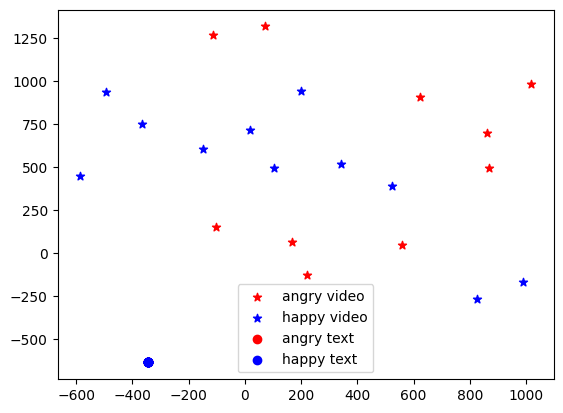

In [36]:
# visualize
embed_tsne = tsne.fit_transform(embed_feats)
feat_len = len(embed_vis_feats)

vis_tsne = embed_tsne[:len(embed_vis_feats)]
text_tsne = embed_tsne[len(embed_vis_feats):]
plt.scatter(vis_tsne[angry_idx, 0], vis_tsne[angry_idx, 1], c='r', marker='*', label='angry video')
plt.scatter(vis_tsne[happy_idx, 0], vis_tsne[happy_idx, 1], c='b', marker='*', label='happy video')
plt.scatter(text_tsne[angry_idx, 0], text_tsne[angry_idx, 1], c='r', marker='o', label='angry text')
plt.scatter(text_tsne[happy_idx, 0], text_tsne[happy_idx, 1], c='b', marker='o', label='happy text')
plt.legend()
plt.show()